# Example 1 : Looking at a MUSIC ROOT data file using uproot

In this first example notebook we will get a feel for using uproot to open a ROOT file containing MUSIC data. Having read the ROOT data into arrays which can manipulate in python, we will then make a couple of basic plots to look at the data. First we will load in the the primary python tools we will be using, pandas, numpy and matplotlib. To make the plots a little nicer in Jupyter we will change some params too.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

In this directory you should see a ROOT file "test_music_data.root" which has some data from an experiment which had a $^{20}$Ne beam on methane gas inside of MUSIC. Lets import uproot and take a look at the data.

In [2]:
import uproot

To open the file we use the open function in uproot.

In [3]:
file = uproot.open("test_music_data.root")

print(type(file))

<class 'uproot.reading.ReadOnlyDirectory'>


We can extract the keys just like any python dictionary.

In [4]:
file.keys()

['tree;2', 'tree;1']

Or we can get the classes.

In [5]:
file.classnames()

{'tree;2': 'TTree', 'tree;1': 'TTree'}

Let's now create an object to access the first tree and look at the keys within the tree structure.

In [6]:
tree = file['tree;1']

tree.keys()

['edepl',
 'edepr',
 'seg',
 'regl',
 'regr',
 'cath',
 'grid',
 'strip0',
 'strip17',
 'tac']

Now we can see some structure which is closer to the things we think of with MUSIC (strip0, cath for cathode etc...). Just like in ROOT we can get more info using show.

In [7]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
edepl                | float                    | AsDtype('>f4')
edepr                | float                    | AsDtype('>f4')
seg                  | int32_t                  | AsDtype('>i4')
regl                 | int32_t                  | AsDtype('>i4')
regr                 | int32_t                  | AsDtype('>i4')
cath                 | float                    | AsDtype('>f4')
grid                 | float                    | AsDtype('>f4')
strip0               | float                    | AsDtype('>f4')
strip17              | float                    | AsDtype('>f4')
tac                  | float                    | AsDtype('>f4')


To make accessing the branches a little easier we can build them into an array. Uproot has a function to do this.

In [8]:
branches = tree.arrays()

print(type(branches))

<class 'awkward.highlevel.Array'>


Notice we didn't get an explicit numpy class back when we printed what type of object "branches" is. These are "Awkward arrays". You may have noticed when installing uproot it also installed the Python package awkward. Without going into too much detail, this package is good at handleing arrays that are not the same size (among some other edge cases). With numpy you would need to handle arrays of unequal length your self, awkward just saves you the trouble (where the awkward arrays have structure similar to numpy arrays as well). 

With the "branches" object we can easily grab data just like a numpy array. For example, if we want to look at the first entry for strip 0 of the anode we can do

In [9]:
branches['strip0'][0]

1003.0

When you are first looking at MUSIC data there are a handfull of plots that are the typical "go-to first things to look at" for a MUSIC run. One such example is a 1D histogram of either strip 0 or the grid energy. With the branches setup into arrays we can build a histogram with matplotlib. Here is a histogram of strip 0.

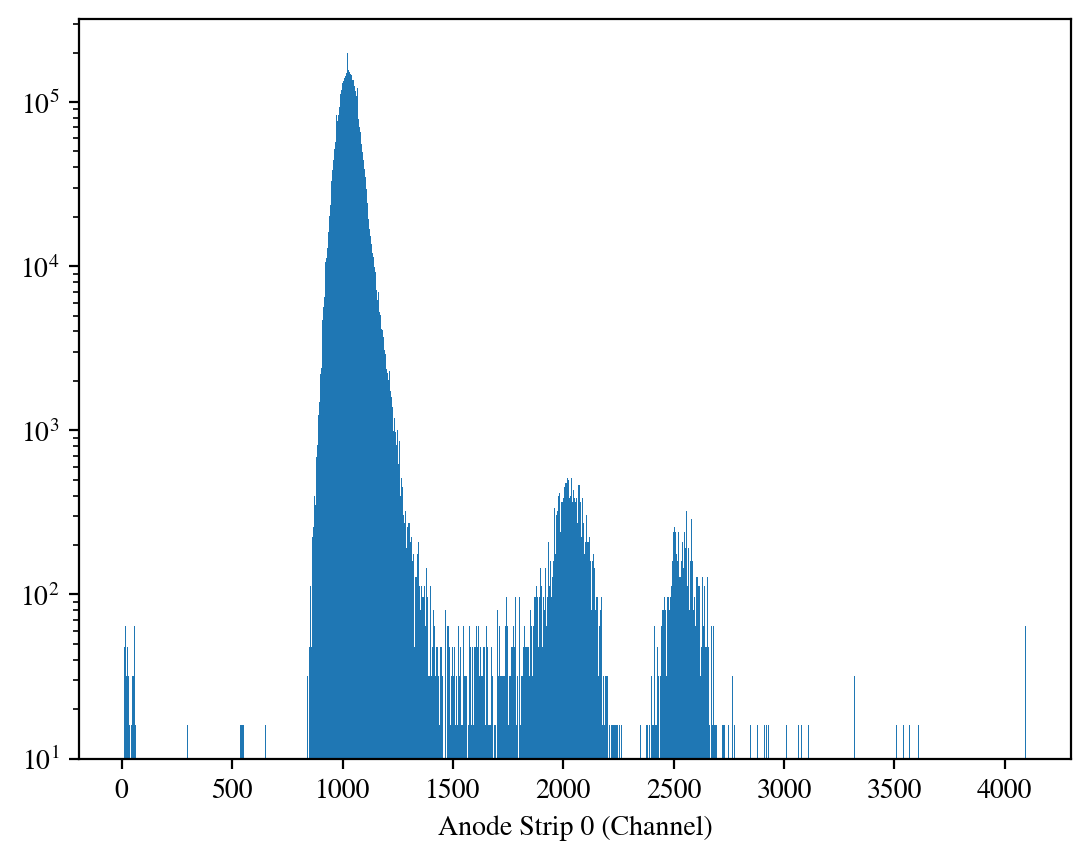

In [10]:
plt.hist(branches['strip0'],
            bins=1000)
plt.xlabel('Anode Strip 0 (Channel)')
plt.yscale('log')

plt.show()

Another common thing to look at is a 2D histogram, often as a $\Delta$E vs. $\Delta$E plot (anode strip vs. anode strip) or as a $\Delta$E vs. Total E plot (say, strip 0 vs. grid). Here, we can even give it the "COLZ" look from ROOT using a norm function. In matplotlib the colors module has several functions for normalizing a colormap. The LogNorm norm function will map values onto the interval [0,1] on a log scale, however bins with zero entries will be "clipped" by default which gives the zero bins a special color in the colormap. This gives you that COLZ look from ROOT.

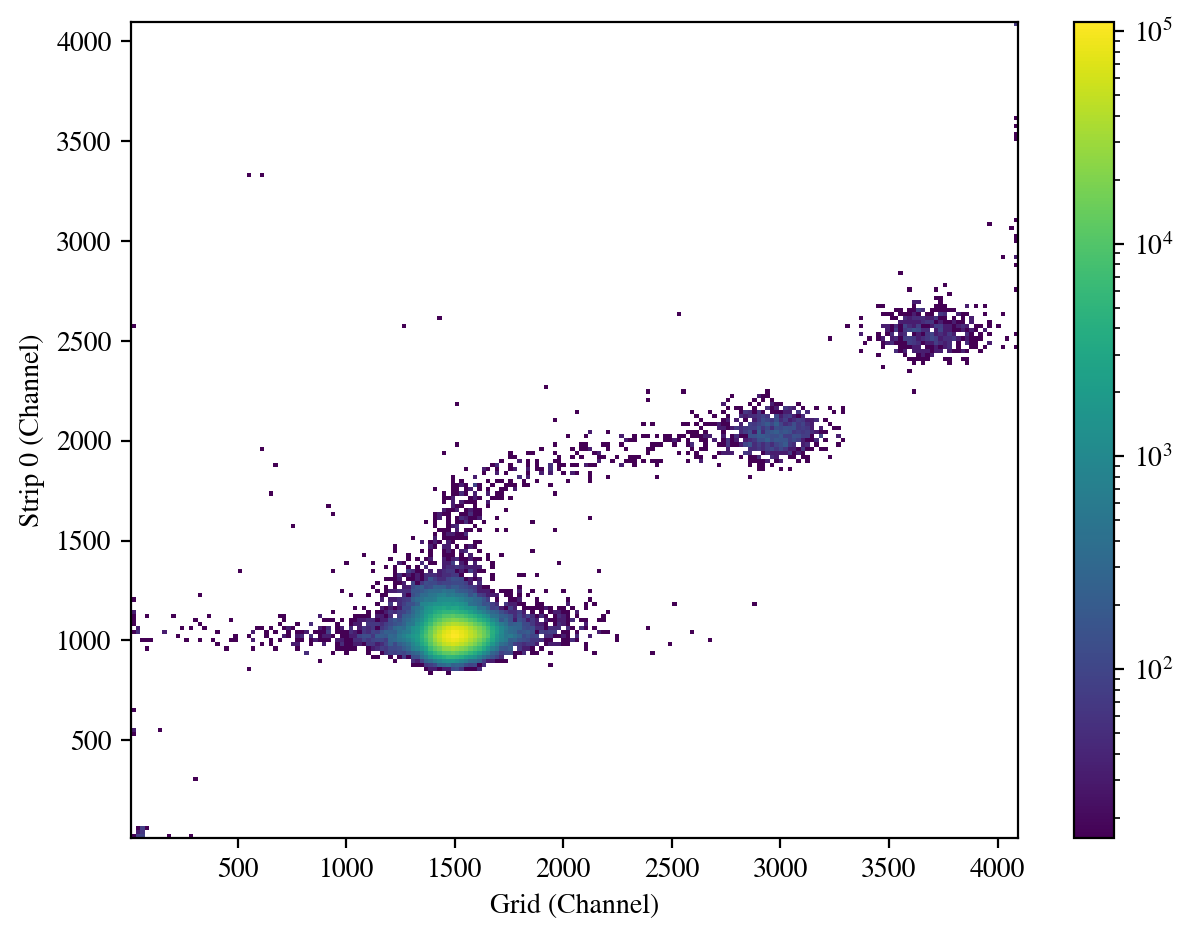

In [11]:
from matplotlib.colors import LogNorm

plt.hist2d(branches['grid'], branches['strip0'],
           bins=200,
           norm=LogNorm())
plt.xlabel('Grid (Channel)')
plt.ylabel('Strip 0 (Channel)')

plt.colorbar()
plt.tight_layout()
plt.show()

Now we can clearly see our beam (blob at grid $\approx$ 1500 and strip 0 $\approx$ 1000). We can also see a structure which looks like pileup of the beam (blob at grid $\approx$ 3000 and strip 0 $\approx$ 2000, two particles moving in MUSIC at the same time thus giving twice the energy loss and twice the total energy deposited). Matplotlib by default uses the viridis colormap, which is a perceptually uniform sequential color scale. If you want to learn more about why one would want to use a colormap like this see [$\textit{The misuse of colour in science communication}$](https://www.nature.com/articles/s41467-020-19160-7) by Crameri, Shephard and Heron. However, matplotlib being a rather feature rich package, we can easily setup a custom colormap to get a more ROOT-esque style colorbar. 

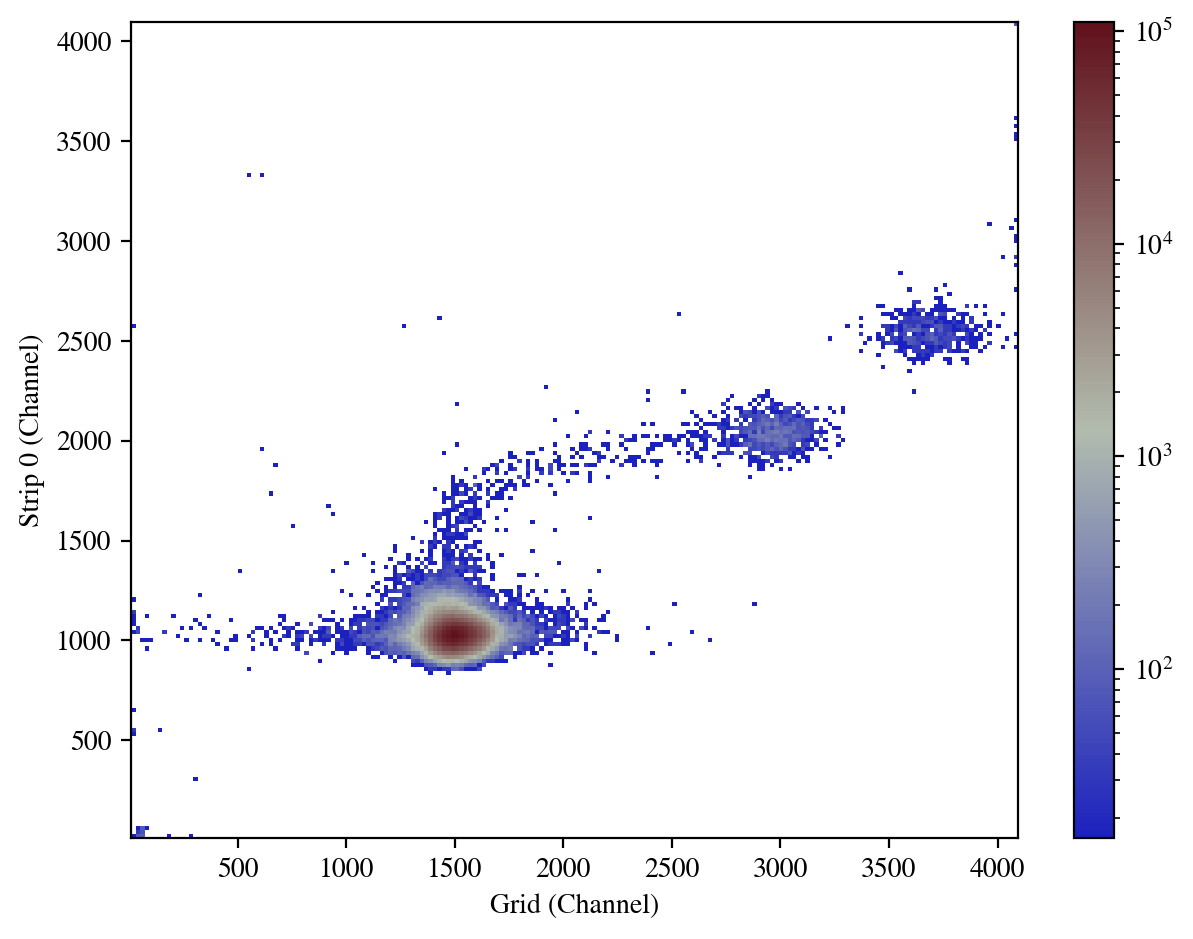

In [12]:
# ROOT-esque colormap
cmap_r = mpl.colors.LinearSegmentedColormap.from_list("ROOT-esque", ["#1b21be",'#b2bcae',"#61111b"])

plt.hist2d(branches['grid'], branches['strip0'],
           bins=200,
           cmap=cmap_r,
           norm=LogNorm())
plt.xlabel('Grid (Channel)')
plt.ylabel('Strip 0 (Channel)')

plt.colorbar()
plt.tight_layout()
plt.show()

Aside from a $\Delta$E vs E plot, the next common initial plot one might want to look at is the signals across the segmeneted anode. Particularly, the left and right strips individually as one wants to see the alternating pattern from the beam (beam goes through L1 then R2 then L3 then R4 etc...). Since the events where the energy loss signal from the unreacted beam should be, by far, the most numerous event this kind of plot serves as a good sanity check that you have at the very least a "typical" MUSIC run. This also serves as a good motivator for why the MUSIC data in the ROOT file had the structure it did. The segment branch "seg" might have seemed a little superflous, but it does make building the 2D histograms a little easier. Some example code using matplotlib can be seen below.

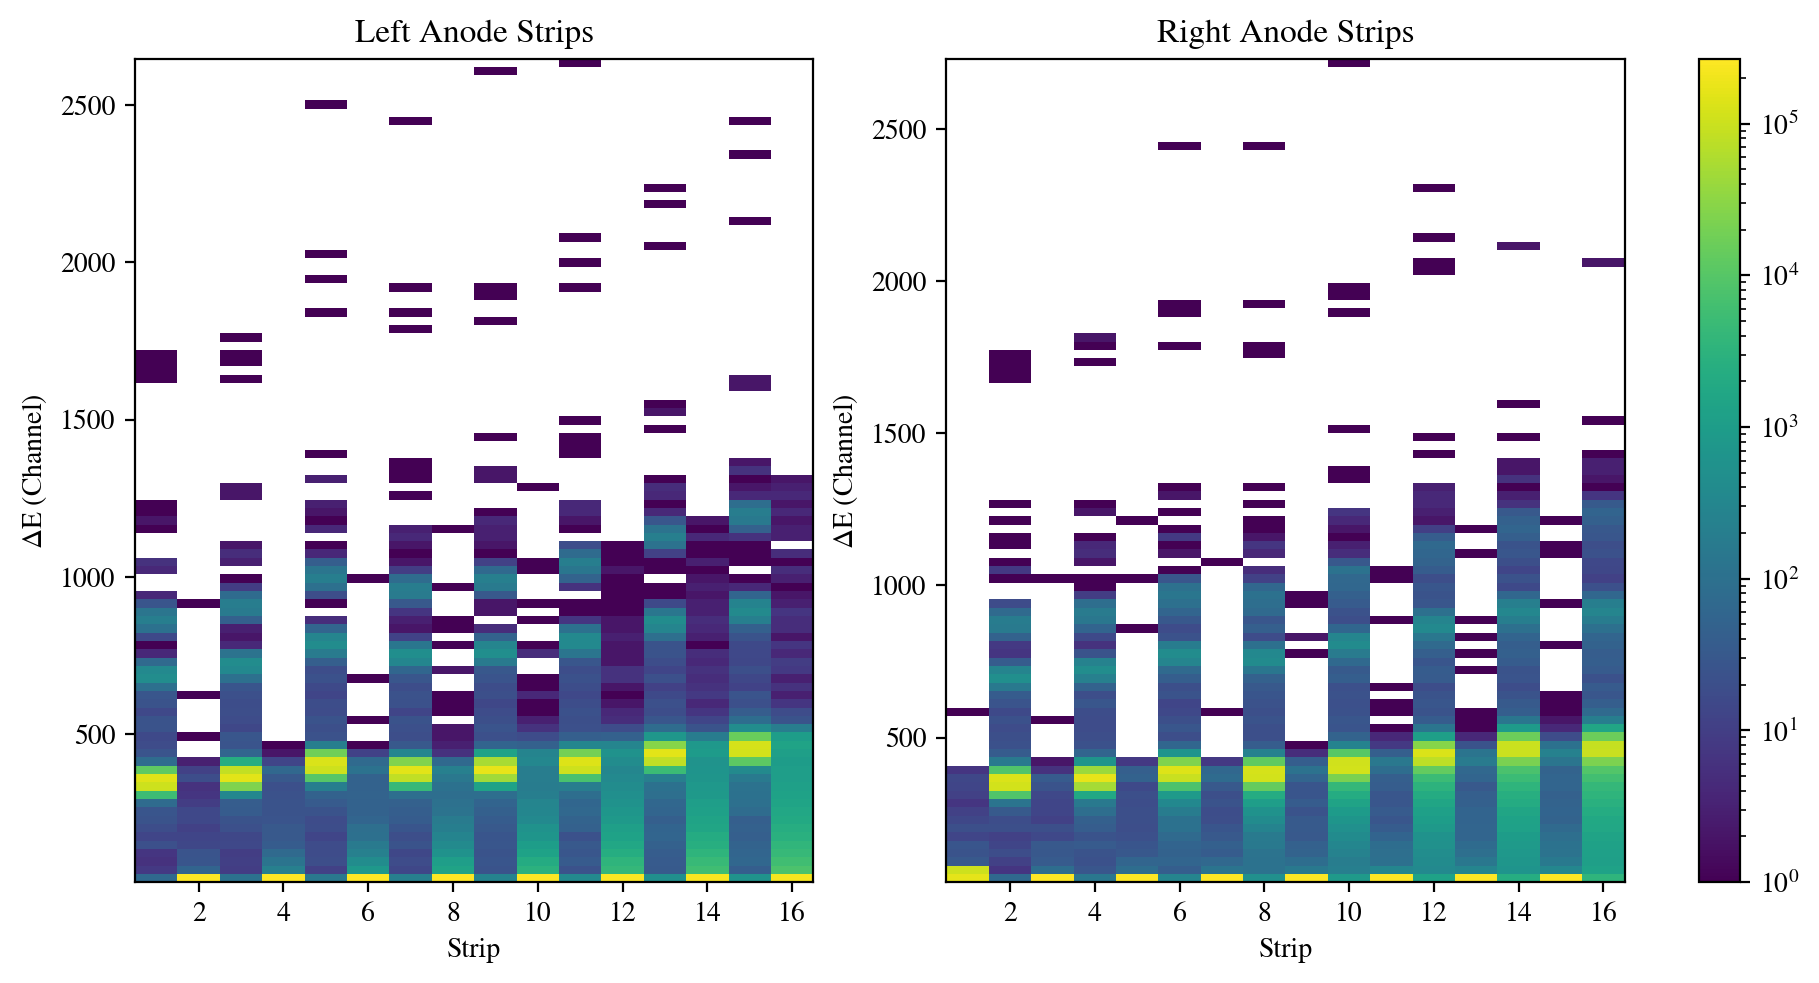

In [13]:
fig, (axL,axR) = plt.subplots(1,2, layout='compressed')
#
axL.set_title('Left Anode Strips')
left_anode = axL.hist2d(branches['seg'], branches['edepl'],
                        bins=[np.arange(1,18)-0.5, # x-axis ticks for strip number in middle of bin
                              # for y-axis give 100 bins spread over the min and max edepl values
                              np.linspace(np.min(branches['edepl']),np.max(branches['edepl']),100)],
                        norm=LogNorm())
axR.set_title('Right Anode Strips')
right_anode = axR.hist2d(branches['seg'], branches['edepr'],
                         bins=[np.arange(1,18)-0.5,
                               np.linspace(np.min(branches['edepr']),np.max(branches['edepr']),100)],
                         norm=LogNorm())
# colorbar
cbar = plt.colorbar(right_anode[3], ax=(axL,axR)) # 

for axes in (axL,axR):
    axes.set_xlabel('Strip')
    axes.set_ylabel(r'$\Delta$E (Channel)')

fig.set_figwidth(9) # in inches
plt.show()